<a href="https://colab.research.google.com/github/DiegoBores/Clickbait-detector/blob/main/Detector_de_Clickbait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Instalamos la biblioteca de TensorFlow, y los modelos de la versión 2.7.0, e importamos las librerias que vamos a utilizar

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 5.4 MB/s 


In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 237 kB 46.4 MB/s 
     |████████████████████████████████| 1.1 MB 37.4 MB/s 
     |████████████████████████████████| 47.8 MB 66 kB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
     |████████████████████████████████| 43 kB 1.0 MB/s 
     |████████████████████████████████| 4.9 MB 38.2 MB/s 
     |████████████████████████████████| 352 kB 41.4 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
     |████████████████████████████████| 90 kB 4.8 MB/s 
     |████████████████████████████████| 99 kB 5.0 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from official.nlp import optimization #for  AdamW optimizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score


# Dataset y análisis descriptivo

En primer lugar obtenemos el dataset desde los enlaces correspondientes. Se trata de dos ficheros .csv que se encuentran en :


*   Conjunto de entrenamiento: https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv

*   Conjunto de test: https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv




In [ ]:
#Obtenemos las URL y los path relativos correspondientes a los dataset de entrenamiento y de test
TRAIN_DATA_URL = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv"#URL del conjunto de entrenamiento
TEST_DATA_URL = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv"#URL del conjunto de test

#Descargamos los datasets
train_file_path = tf.keras.utils.get_file("webis_train.csv", TRAIN_DATA_URL,
                                          cache_dir='.', cache_subdir='datasets')
test_file_path = tf.keras.utils.get_file('webis_test.csv', TEST_DATA_URL,
                                         cache_dir='.', cache_subdir='datasets')

90128384/90117240 [==============================] - 5s 0us/step


In [ ]:
#Leemos los csv y los almacenamos en sendos dataframes de pandas
train_df = pd.read_csv(train_file_path) 
test_df = pd.read_csv(test_file_path)



> # Análisis del contenido 


El dataset que vamos a utilizar cuenta con varias columnas correspondientes a la información de cada tweet (target), incluyendo contenido multimedia e información de los enlaces incluidos en el post, y varias columnas correspondientes a los datos relativos a la clasificaion (truth). De acuerdo con https://webis.de/data/webis-clickbait-17.html , la clasificación se ha realizado mediante una escala de 4 valores (0: no es clikbait, 0.33: ligeramente clickbait, 0.66: considerablemente clickbait, 1 altamente clickbait), por cinco observadores. Por lo tanto, se decide que es clickbait si la media de los valores indicados por los observadores es mayor que 0.5.





In [ ]:
#Podemos ver una muestra del dataset de entrenamiento
train_df.sample(5)

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
1662,1662,['media/photo_812422043962482688.jpg'],Referral hiring is great for employees and emp...,812422046386978816,[],['Almost everyone wins when it comes to referr...,Hiring an Employee's Buddy Is Fueling a Major ...,Fri Dec 23 22:18:04 +0000 2016,NaN,The best way to get new talent isn't great for...,"[1.0, 0.0, 0.33333333330000003, 0.0, 0.0]",0.266667,no-clickbait,0.000000,0.000000
19163,19163,['media/photo_813869211596574722.jpg'],The awesome life and career of 'Star Wars' ico...,813869213416910848,[],"['Jason Guerrasio', '27.12.2016, 23:07 487', '...",The awesome life and career of 'Star Wars' ico...,Tue Dec 27 22:08:36 +0000 2016,NaN,"Carrie Fisher had a rich, productive life in H...","[0.0, 0.33333333330000003, 0.0, 0.0, 0.0]",0.066667,no-clickbait,0.000000,0.000000
10554,10554,['media/photo_836729218021064704.jpg'],Why open data is key to open markets in the er...,836729220789317632,['Target Gets a Lesson That Low Prices Matter'...,['SAN FRANCISCO — Access to the tools of artif...,Open Data Is Key to Open Markets in Era of AI ...,Wed Mar 01 00:06:06 +0000 2017,"ANDREW NG,BAIDU,NEIL JACOBSTEIN,SINGULARITY UN...",Access to the tools of artificial intelligence...,"[0.6666666666000001, 0.6666666666000001, 0.333...",0.533333,clickbait,0.666667,0.666667
1464,1464,[],Man fired after skipping work for son's birth ...,817814818837172224,['A father sacked for skipping work when his w...,"['More', 'A new father who was sacked for miss...",Father sacked for missing work for son's birth...,Sat Jan 07 19:27:01 +0000 2017,NaN,A new father who was sacked for missing work f...,"[0.33333333330000003, 0.0, 1.0, 0.0, 0.6666666...",0.400000,no-clickbait,0.333333,0.000000
4650,4650,['media/photo_837717719394959360.jpg'],Patrick Stewart is applying for U.S. citizensh...,837717722154827776,['Patrick Stewart says he’s retiring from the ...,"['More', 'Patrick Stewart says he’s going to a...",Patrick Stewart Applying for U.S. Citizenship ...,Fri Mar 03 17:34:03 +0000 2017,NaN,Patrick Stewart says he’s going to apply for U...,"[0.33333333330000003, 0.33333333330000003, 0.3...",0.266667,no-clickbait,0.333333,0.333333


Comprobamos que no haya valores null en los campos que nos interesan

In [ ]:
train_df.isnull().any()

Unnamed: 0           False
postMedia            False
postText              True
id                   False
targetCaptions       False
targetParagraphs     False
targetTitle          False
postTimestamp        False
targetKeywords        True
targetDescription     True
truthJudgments       False
truthMean            False
truthClass           False
truthMedian          False
truthMode            False
dtype: bool

In [ ]:
test_df.isnull().any()

Unnamed: 0           False
id                   False
postMedia            False
targetCaptions       False
postText              True
postTimestamp        False
targetTitle          False
targetDescription     True
targetKeywords        True
targetParagraphs     False
truthJudgments       False
truthClass           False
truthMedian          False
truthMode            False
truthMean            False
dtype: bool

Puesto que la columna de texto que nos interesa tiene valores Null, debemos eliminarlos para que no nos de problemas a la hora de entrenar el modelo



In [ ]:
train_df = train_df.dropna(how='any',subset=['postText', 'truthClass'], axis=0)
test_df = test_df.dropna(how='any',subset=['postText', 'truthClass'], axis=0)

In [ ]:
#Cambiamos los valores de 'truthClass' a valores 1 o 0 en funcion de si es un clickbait o no
#En el conjunto de entrenamiento
train_df['truthClass'] = train_df['truthClass'].apply(lambda x: 1 if x=='clickbait' else 0 )
train_df.rename(columns={'truthClass':'target'}, inplace=True)
#En el conjunto de test
test_df['truthClass'] = test_df['truthClass'].apply(lambda x: 1 if x=='clickbait' else 0 )
test_df.rename(columns={'truthClass':'target'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [ ]:
#contamos  cuantos ejemplos del dataset de entrenamiento contienen un clickbait y cuantos no
train_df['target'].value_counts()

0    14768
1     4716
Name: target, dtype: int64



> # Análisis de las muestras


Un 25% de los valores son clickbait. Implica un desbalanceo entre las clases que podría conducir a un alto sesgo durante el entrenamiento del modelo. Para evitar esta situación vamos a intentar balancear los datos, eliminando elementos que contengan 'no-clickbait' hasta que igualen a los de 'clikbait'. 
Además, por motivos de limitaciones computacionales y de tiempo, la reducción del conjunto de entrenamiento agiliza las pruebas, si bien podría conducir a un problema de alta varianza por falta de datos. 


In [ ]:
df_clickbait = train_df[train_df['target']==1]
df_noclickbait = train_df[train_df['target']==0]

df_noclickbait_downsampled=df_noclickbait.sample(df_clickbait.shape[0])

train_df = pd.concat([df_noclickbait_downsampled, df_clickbait])
# train_df=train_df.sample(8000)#Reducimos el tamaño del dataset por motivos computacionales
del df_clickbait, df_noclickbait, df_noclickbait_downsampled

In [ ]:
train_df['target'].value_counts()

0    4716
1    4716
Name: target, dtype: int64

Dividimos el dataset en train y validation, en una relacion 80/20, para poder representar las curvas de aprendizaje y comparar como se comporta el modelo en el entrenamiento y cómo es capaza de generalizar a nuevos ejemplos, y su evolución con el número de iteraciones.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df['postText'],train_df['target'], train_size=0.8)
del train_df

Vamos a extraer del conjunto de test las columnas que nos interesan, y en el mismo formato que los de entrenamiento:

In [ ]:
X_test = test_df['postText']
y_test = test_df['target']


# Modelos a utilizar:

Por limitaciones de recursos computacionales y del funcionamiento de la versión gratuita de Google colab ( he entrenado varias veces 2 modelos diferentes y en todos he perdido el modelo entrenado por haber alcanzado la limitación de uso de GPU), se entrenará un único modelo, que será small BERT


> # Small BERT

Se trata de un modelo basado en BERT original, pero con menos bloques Transformer y/o más pequeños.

Utilizaremos el modelo Small BERT con configuración L12, H738, A12





In [ ]:
smallBERT_preprocess_handle = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
smallBERT_encoder_handle = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)


 > > > # Modelo de preprocesado


Las entradas de texto deben ser transformadas a tokens numericoas y agrupados en tensores antes de ser entradas de BERT. TensorFlow Hub facilita un modelo de preprocesamiento para cada modelo BERT por lo que no es necesario correr codigo de Python especifico fura del modelo de TensorFlow para preprocesar el texto.

Del preprocesado hay tres salidas principales, que serán las utilizadas por el modelo BERT: ,  e 


*  input_words_id: simplemente el identificador de frase
*  input_mask: para indicar al modelo BERT qué tokens corresponden a padding.
*  input_type_ids: los tokens en que se ha transformado el texto de entrada






> > > # Modelo BERT

Los modelos BERT devuelven un map con 3 keys importantes: pooled_output, sequence_output y encoder_outputs:


*   pooled_output representa cada frase de entrada como un conjunto. Las dimensiones son [batch_size, H].


*   sequence_output representa cada token de entrada en el contexto. Las dimensiones son [batch_size, seq_length, H].


*   encoder_outputs son las activaciones intermedias de los L bloques Transformer.

Para el fine-tunning se utiliza el array pooled_output

> > > # Definicion del modelo

El modelo utilizado es sencillo:  el preprocesado, el modelo Small BERT, una capa Dropout y una capa Dense.

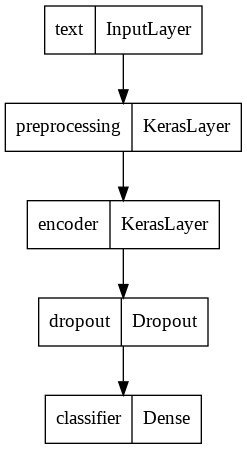


In [ ]:
#Crearemos una función que construya el modelo a apartir de las url del modulo de preprocesado y del modulo BERT empleado
def build_classifier_model(preprocess_handle, encoder_handle):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_handle, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_handle, trainable = True, name='encoder')
  outputs = encoder(encoder_inputs)
  net=outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)


Vamos a echar un vistazo al esquema del modelo



In [ ]:
smallBERT_classifier_model = build_classifier_model(smallBERT_preprocess_handle , smallBERT_encoder_handle)
del smallBERT_preprocess_handle, smallBERT_encoder_handle

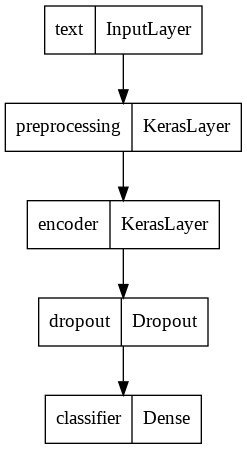

In [ ]:
tf.keras.utils.plot_model(smallBERT_classifier_model)

In [ ]:
smallBERT_classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

> > > # Función de pérdidas, optimizador y metricas

Dado que se trata de un problema de clasificacion binaria, y la salida del modelo es una probabilidad (es una capa con una única unidad), utilizaremos la funcion de costes losses.BinaryCrossentropy:



In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()

Las métricas que utilizaremos son :

*   Accuracy: mide la frecuencia con la que la predicción coincide con el valor real. Sin embargo, cuando las clases estan desbalanceads esta métrica puede llevar a error
*   Precission: del conjunto de ejemplos clasificados como 'clickbait', indica cuántos realmente lo son.
*   Recall: del conjunto real de ejemplos clasificados 'clickbait', nos indica cuántos fueron detectados. 

In [ ]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precission'),
           tf.keras.metrics.Recall(name='recall')
]

Para el fine-tunning utilizaremos el mismo optimizador Adamw, que minimiza la perdida de la prediccion y emplea regularización mediante disminucion de pesos (no emplea momentos), que se conoce como AdamW.

Para la tasa de aprendizaje (init_lr) emplearemos el mismo esquema que en el pre-entrenamiento de BERT: disminucion linear de una tasa inicial, prefijada con una fase de calentamiento linear sobre el 10% de los pasos de entrenamiento(num_warmup_steps). De acuerdo con el paper de BERT, la tasa de aprendizaje inicial debe ser más pequeña para el fine-tunning( mejor de 5e-5, 3e-5, 2e-5)

In [ ]:
epochs = 7 #numero de epochs inicialmente 1
batch_size=32 #tamaño de batch 
steps_per_epoch = len(X_train)/batch_size #Definimos el número de pasos 
num_train_steps = steps_per_epoch * epochs #Numero de pasos de entrenamiento
num_warmup_steps = int(0.1*num_train_steps) #Numero de pasos de calentamiento

#Tasa de aprendizaje inicial
init_lr = 5e-5

optimizer = optimization.create_optimizer(init_lr = init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

> > > # Compilando el modelo y fine-tunning

A continuación, compilamos el modelo definido anteriormente. 



In [ ]:
smallBERT_classifier_model.compile(optimizer= optimizer,
                                   loss=loss,
                                   metrics = METRICS)

Y realizamos el fine-tunning. Por limitaciones computacionales y de tiempo, reduciremos el numero de epochs a 7, si bien este numero debería ser bastante mayor. 

In [ ]:
smallBERT_history = smallBERT_classifier_model.fit(X_train,y_train, 
                                                   validation_data=(X_val, y_val),
                                                   batch_size=batch_size, 
                                                   epochs=epochs)

Epoch 1/7
236/236 [==============================] - 492s 2s/step - loss: 0.4944 - accuracy: 0.7593 - precission: 0.7723 - recall: 0.7298 - val_loss: 0.4191 - val_accuracy: 0.8251 - val_precission: 0.8034 - val_recall: 0.8759
Epoch 2/7
236/236 [==============================] - 473s 2s/step - loss: 0.3450 - accuracy: 0.8565 - precission: 0.8488 - recall: 0.8645 - val_loss: 0.4286 - val_accuracy: 0.8288 - val_precission: 0.8141 - val_recall: 0.8667
Epoch 3/7
236/236 [==============================] - 474s 2s/step - loss: 0.1775 - accuracy: 0.9359 - precission: 0.9222 - recall: 0.9508 - val_loss: 0.5986 - val_accuracy: 0.8182 - val_precission: 0.8398 - val_recall: 0.8010
Epoch 4/7
236/236 [==============================] - 464s 2s/step - loss: 0.0857 - accuracy: 0.9720 - precission: 0.9640 - recall: 0.9802 - val_loss: 0.9148 - val_accuracy: 0.8103 - val_precission: 0.7908 - val_recall: 0.8605
Epoch 5/7
236/236 [==============================] - 463s 2s/step - loss: 0.0370 - accuracy: 0.9

Métricas obtenidas durante el fine-tunning:

Epoch 1/7
236/236 [==============================] - 492s 2s/step - loss: 0.4944 - accuracy: 0.7593 - precission: 0.7723 - recall: 0.7298 - val_loss: 0.4191 - val_accuracy: 0.8251 - val_precission: 0.8034 - val_recall: 0.8759

Epoch 2/7
236/236 [==============================] - 473s 2s/step - loss: 0.3450 - accuracy: 0.8565 - precission: 0.8488 - recall: 0.8645 - val_loss: 0.4286 - val_accuracy: 0.8288 - val_precission: 0.8141 - val_recall: 0.8667

Epoch 3/7
236/236 [==============================] - 474s 2s/step - loss: 0.1775 - accuracy: 0.9359 - precission: 0.9222 - recall: 0.9508 - val_loss: 0.5986 - val_accuracy: 0.8182 - val_precission: 0.8398 - val_recall: 0.8010

Epoch 4/7
236/236 [==============================] - 464s 2s/step - loss: 0.0857 - accuracy: 0.9720 - precission: 0.9640 - recall: 0.9802 - val_loss: 0.9148 - val_accuracy: 0.8103 - val_precission: 0.7908 - val_recall: 0.8605

Epoch 5/7
236/236 [==============================] - 463s 2s/step - loss: 0.0370 - accuracy: 0.9894 - precission: 0.9875 - recall: 0.9912 - val_loss: 1.2007 - val_accuracy: 0.8108 - val_precission: 0.8018 - val_recall: 0.8421

Epoch 6/7
236/236 [==============================] - 465s 2s/step - loss: 0.0209 - accuracy: 0.9935 - precission: 0.9920 - recall: 0.9949 - val_loss: 1.3133 - val_accuracy: 0.8066 - val_precission: 0.8062 - val_recall: 0.8236

Epoch 7/7
236/236 [==============================] - 465s 2s/step - loss: 0.0155 - accuracy: 0.9959 - precission: 0.9949 - recall: 0.9968 - val_loss: 1.3421 - val_accuracy: 0.8076 - val_precission: 0.8060 - val_recall: 0.8267

Vamos a empezar describiendo la evolución de la función de pérdidas. En entrenamiento, el decrecimiento es muy rápido, llegando a alcanzar en 7 iteraciones un valor de 0.0155. Sin embargo, en el conjunto de validación obtiene un valor muy elevado (1.3421), lo cual nos podría indicar que el modelo se está sobreajustando al conjunto de entrenamiento, y no es capaz de generalizar a nuevos ejemplos. Es decir, podríamos estar ante un caso de alta varianza.

Por su parte, la métrica accuracy alcanza el 99.59 % en el conjunto de entrenamiento, y las métricas de precission y recall obtienen similar y muy elevado (en torno al 99.5 %). Pero de nuevo se puede observar la diferencia con respecto a los resultados en el conjunto de validación. 

Para ver esta evolución, más adelante hemos representado la curva de aprendizaje, que podemos ver a continuación:

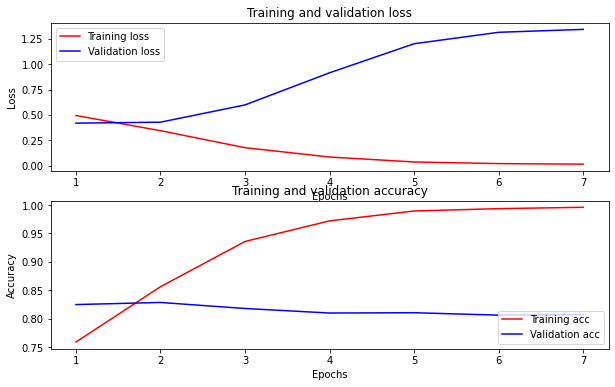

De nuevo, vemos como la función de costes en el conjunto de validación, lejos de disminuir con cada iteración, crece desde el primer momento. 

Puesto que el optimizador AdamW ya aplica regularización, una solución a este problema de alta varianza podría ser aumentar el conjunto de datos empleado. También se podría intensificar la regularización o aplicar métodos como la detección temprana, que consiste en parar el fine-tunning cuando la curva de la función de costes en el conjunto de validación alcanza el mínimo, aunque en este caso el mínimo se obtiene  al principio y el valor de la función de costes es elevado. 

dict_keys(['loss', 'accuracy', 'precission', 'recall', 'val_loss', 'val_accuracy', 'val_precission', 'val_recall'])


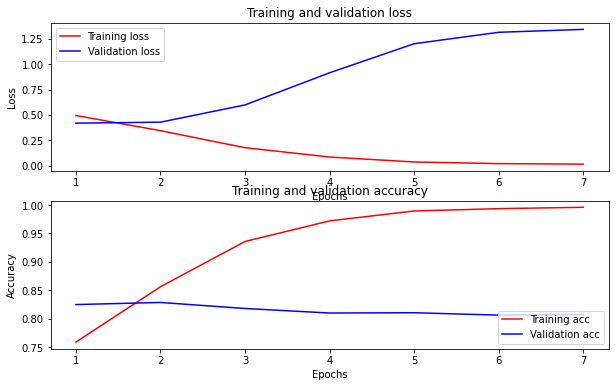

In [ ]:
history_dict = smallBERT_history.history
print(history_dict.keys())

smallBERT_acc = history_dict['accuracy']
smallBERT_val_acc = history_dict['val_accuracy']
smallBERT_loss = history_dict['loss']
smallBERT_val_loss = history_dict['val_loss']

epochs = range(1, len(smallBERT_acc) +1)
fig = plt.figure(figsize = (10,6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, smallBERT_loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, smallBERT_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, smallBERT_acc, 'r', label='Training acc')
plt.plot(epochs, smallBERT_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Vamos a exportar el modelo obtenido para utilizarlo mas adelante:

In [ ]:
dataset_name = 'webis'
saved_model_path = './drive/MyDrive/Colab Notebooks/Modelos/{}_smallBERT'.format(dataset_name.replace('/', '_'))
smallBERT_classifier_model.save(saved_model_path, include_optimizer = False)


> > > # Evaluación del modelo

En primer lugar, vamos a evaluar el modelo obtenido en el conjunto de test. 

In [ ]:
smallBERT_metrics= smallBERT_classifier_model.evaluate(X_test, y_test)


592/592 [==============================] - 490s 827ms/step - loss: 1.2598 - accuracy: 0.8135 - precission: 0.5700 - recall: 0.8504


592/592 [==============================] - 490s 827ms/step - loss: 1.2598 - accuracy: 0.8135 - precission: 0.5700 - recall: 0.8504


El resultado obtenido deja bastante que desar, sin embargo podemos extraer algunas conclusiones:

El valor de precission, un 57%, indica que de cada 100 ejemplos que se clasifican como clickbait, sólo 57 son realmente clickbaits. 
Por su parte, el valor de recall nos indica que de todos  los ejemplos que realmente son clickbait en el conjunto de test, el algoritmo detectó el 85%. 

Cabe indicar que el conjunto de test no ha sido balanceado. Vamos a ver qué estructura tiene:

In [ ]:
test_df['target'].value_counts()

0    14455
1     4458
Name: target, dtype: int64

Como en el caso del conjunto de entrenamiento, hay en torno a un 25% de muestras correpondientes a clickbait. sin embargo, los valores de precission y de recall nos indican que el problema del algoritmo no es que esté presente una tendencia a predecir 'no-clickbait', más bien al contrario. 

Vamos a realizar las predicciones sobre las primeras 1000 muestras del conjunto de test, y a obtener los casos en que el modelo falla, para intentar inferir a partir de los datos del dataset el motivo por el que el modelo podría estar fallando. En concreto, vamos a echar un vistazo a las columnas 'postText', truthMean y truthClass(ahora 'target'). 


In [ ]:
smallBERT_classifier_model = tf.saved_model.load('/content/drive/MyDrive/Colab Notebooks/Modelos/webis_smallBERT')

In [ ]:
num_test_items=1000#Numero de muestras del conjunto de test de las que vamos a obtener las predicciones y evaluar los fallos

In [ ]:
predicted_test= smallBERT_classifier_model(X_test[0:num_test_items]) #Obtenemos las predicciones con el modelo obtenido

In [ ]:
# clasificamos como 1 si el resultado es superior a 0.5, y como 0 en caso contrario
predicted_label =(predicted_test.numpy()>0.5)
predicted_label = 1* predicted_label

In [ ]:
results_df=test_df[0:num_test_items] #creamos un df, al que añadiremos la prediccion, con los primeror num_test_items en el conjunto de test

In [ ]:
results_df.insert(15,'prediction',predicted_label[:,0])#añadimos la columna con las predicciones


In [ ]:
#Obtenemos las filas donde la resta entre el valor predicho y el real es distinto de 0, es decir, el modelo falla

diff = results_df['target']-results_df['prediction']
index=diff!=0
results_df = results_df[index]



In [ ]:
pd.set_option('display.max_rows', 100)


In [ ]:
#Echamos un vistazo a los resultados
results_df[['postText', 'truthMean', 'target', 'prediction']].head(100)

,postText,truthMean,target,prediction
4,It's not enough to let employees work flexible...,0.133333,0,1
5,"Out of 15 lakh registered companies in India, ...",0.200000,0,1
6,Tense moment plane lands without wheel,0.533333,0,1
10,Don't abandon the snot if you want to be healt...,0.400000,0,1
37,United Takes Added Steps to Win Back Customers...,0.066667,0,1
41,Undercover video of human organ traders,0.266667,0,1
56,How coral of Great Barrier Reef could be saved...,0.466667,0,1
62,"""Why is Bill Clinton given a pass over the oth...",0.666667,1,0
68,Shea Moisture put out—and promptly pulled—(ano...,0.466667,0,1
74,"New details on teacher's arrest, teen student'...",0.266667,0,1


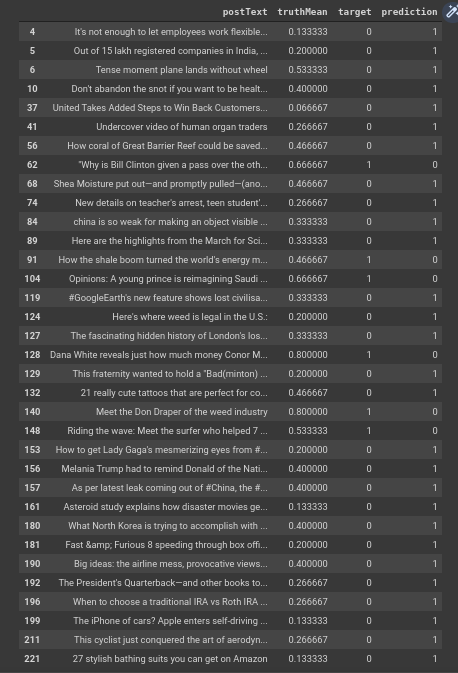
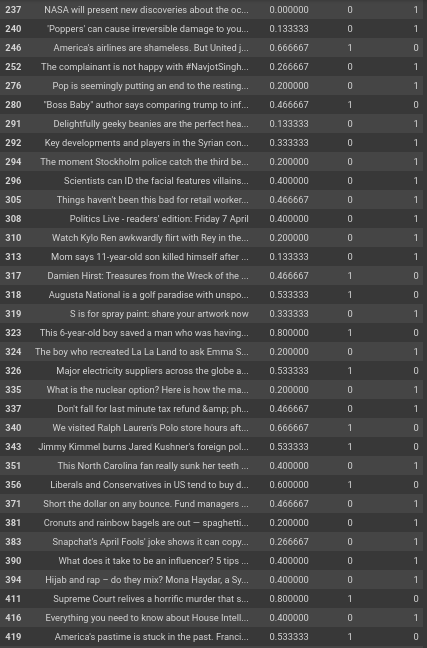

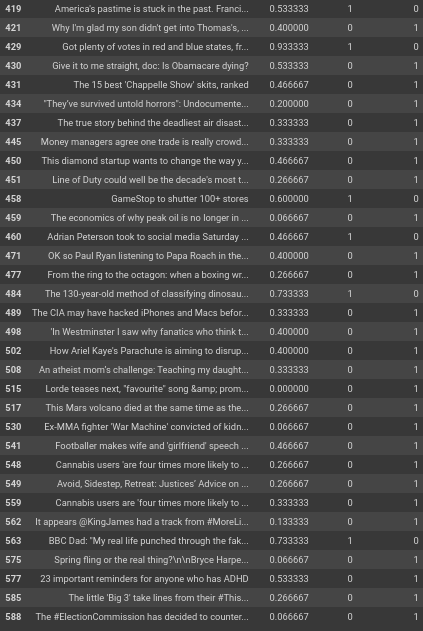

Podemos observar, como se deducía del valor de recall obtenido al evaluar el modelo en el conjunto de test, que la mayoría de errores se producen cuando el modelo predice como clickbait un ejemplo que no lo es. Además, se puede observar que el valor medio de los juicios realizados por los observadores que clasificaron las muestras en la mayoría de casos no son estrictamente 0, sino que a menudo hay valores elevados. 

Cabe destacar, además, que parece haber ejemplos mal clasificados (filas 62 y 91), en las que el valor medio de las voloraciones de los observadores indica lo contrario a lo que muestra el valor de truthClass(ahora target). Sería interesante realizar un estudio sobre estos ejemplos "mal clasificados", que yo no voy a realizar por falta de tiempo, pero que podrían explicar porqué el modelo presenta este error. 

Posibles trabajos futuros siguiendo esta línea serían la comprobación de los ejemplos mal clasificados en el conjunto de entrenamiento, ya que podrían estar afectando al rendimiento del modelo, aumento de datos para intentar evitar el sobreajuste, y optimización de los parámetros. 

El codificador BERT utilizado es uno de los más sencillos disponible, por lo que también sería interesante cómo lo hacen sobre el mismo conjunto otros modelos más complejos. Sin embargo, por limitaciones de tiempo y de recursos computacionales, me he limitado a elaborar un solo modelo y a evaluarlo sobre el conjunto de test.